# **Stock Price Prediction Using Machine Learning And Deep Learning**

Stock market analysis can be conducted following two different way:

- Fundamental Analysis predicts the company's future profitability based on analyzing its current buisness environment and financial performance.
- Technical Analysis involves reading the charts and using statistical modeling to determine the stock market trends and outbreaks.

The following section will focus on the technical analysis through implementing multiple known Machine Learning Models that predicts Netflix stock price. Then, compare the predicted value to the actual price to determine which algorithms can be used for stock market predictions.

**Importing Libraries**

In [ ]:
pip install pmdarima

In [ ]:
pip install prophet

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import datetime
from fastai.tabular.core import  add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

**Getting the data**

In [ ]:
url = 'https://raw.githubusercontent.com/fares1121/Stock-Price-Prediction-Using-Machine-Learning/main/NFLX.csv'
Netflix = pd.read_csv(url)
Netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5355 entries, 0 to 5354
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5355 non-null   object 
 1   Open       5355 non-null   float64
 2   High       5355 non-null   float64
 3   Low        5355 non-null   float64
 4   Close      5355 non-null   float64
 5   Adj Close  5355 non-null   float64
 6   Volume     5355 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 293.0+ KB


In [ ]:
Netflix.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5350,2023-08-24,425.410004,427.589996,406.170013,406.929993,406.929993,5687800
5351,2023-08-25,412.000000,419.250000,407.559998,416.029999,416.029999,5386800
5352,2023-08-28,418.040009,419.829987,413.269989,418.059998,418.059998,2928600
5353,2023-08-29,416.000000,432.170013,414.500000,429.989990,429.989990,4486700
5354,2023-08-30,430.850006,438.160004,428.350006,434.670013,434.670013,3622800


**Visaulizing Netflix Stock Closing Prices**

<Axes: title={'center': 'Close Prices'}, xlabel='Date'>

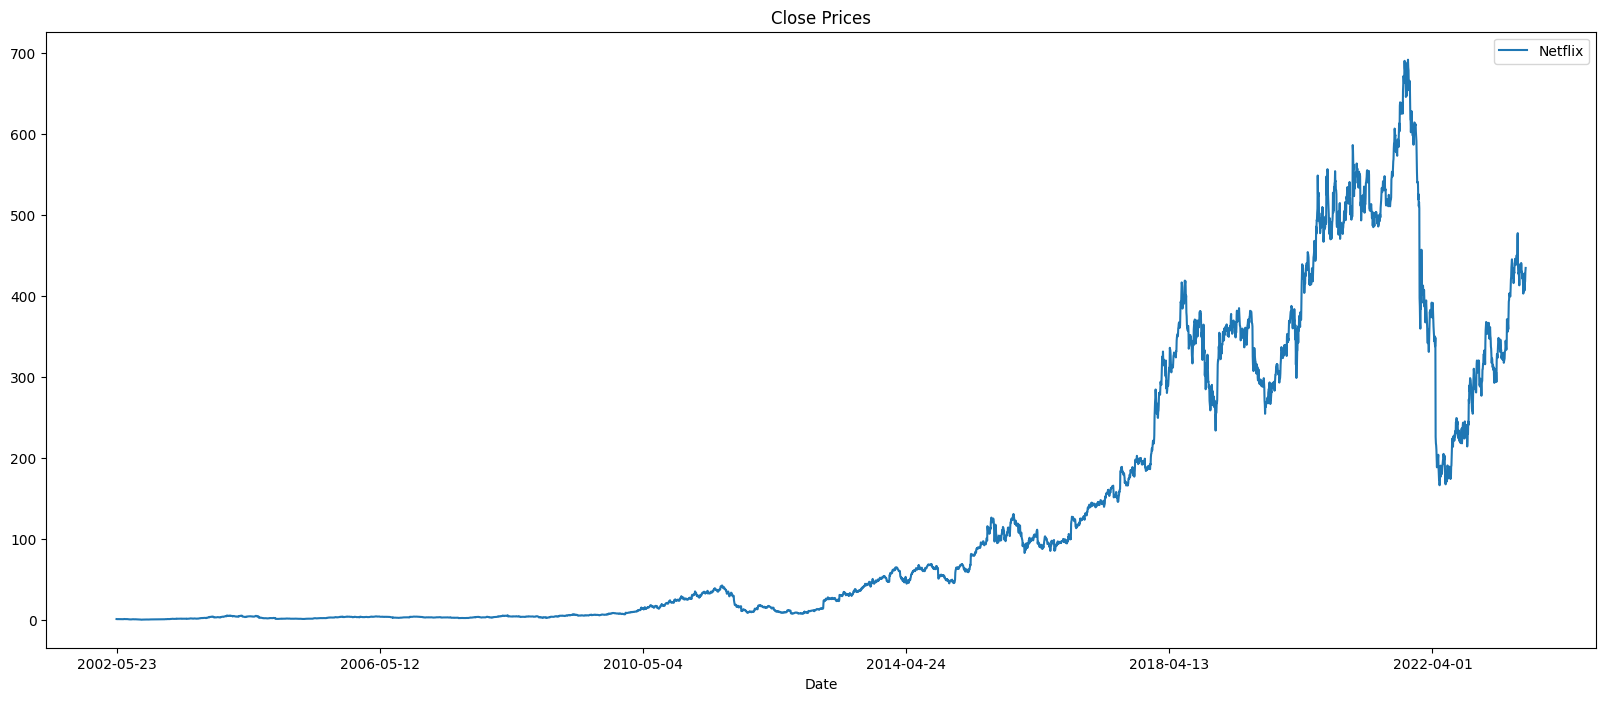

In [ ]:
Netflix.plot(label = 'Netflix', figsize = (20,8), title = 'Close Prices', x = 'Date', y = 'Close')



# Linear regression:





Linear regression is a simple machine learning algorithm that relies in statistical techniques. The predictive model return an equation that determines a relationship between the independent variables and the dependent variable which is the target value that we need to determine.

In [ ]:
data = Netflix.sort_index(ascending=True, axis=0)

In [ ]:
new_data = pd.DataFrame(index=range(0,len(Netflix)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

**Create features**

Used add_datepart from fastai library to create additional features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, ‘Is_year_start’

In [ ]:
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

**split the data into train and validation sets to check the performance of the model**

In [ ]:
train = new_data[:4284]
valid = new_data[4284:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

**Implement the Linear Regression Model**

In [ ]:
linearRegressionModel = LinearRegression()
linearRegressionModel.fit(x_train,y_train)

LinearRegression()

**Make predictions**

In [ ]:
linearRegressionPrediction = linearRegressionModel.predict(x_valid)

**Get RMSE**

In [ ]:
rmse=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(linearRegressionPrediction)),2)))
rmse

231.29268148597694

In [ ]:
print(linearRegressionPrediction)

[199.91976496 186.91561265 187.05327343 ... 245.23796315 245.37562393
 245.51328471]


**Plot the predicted price compared to the actual price**

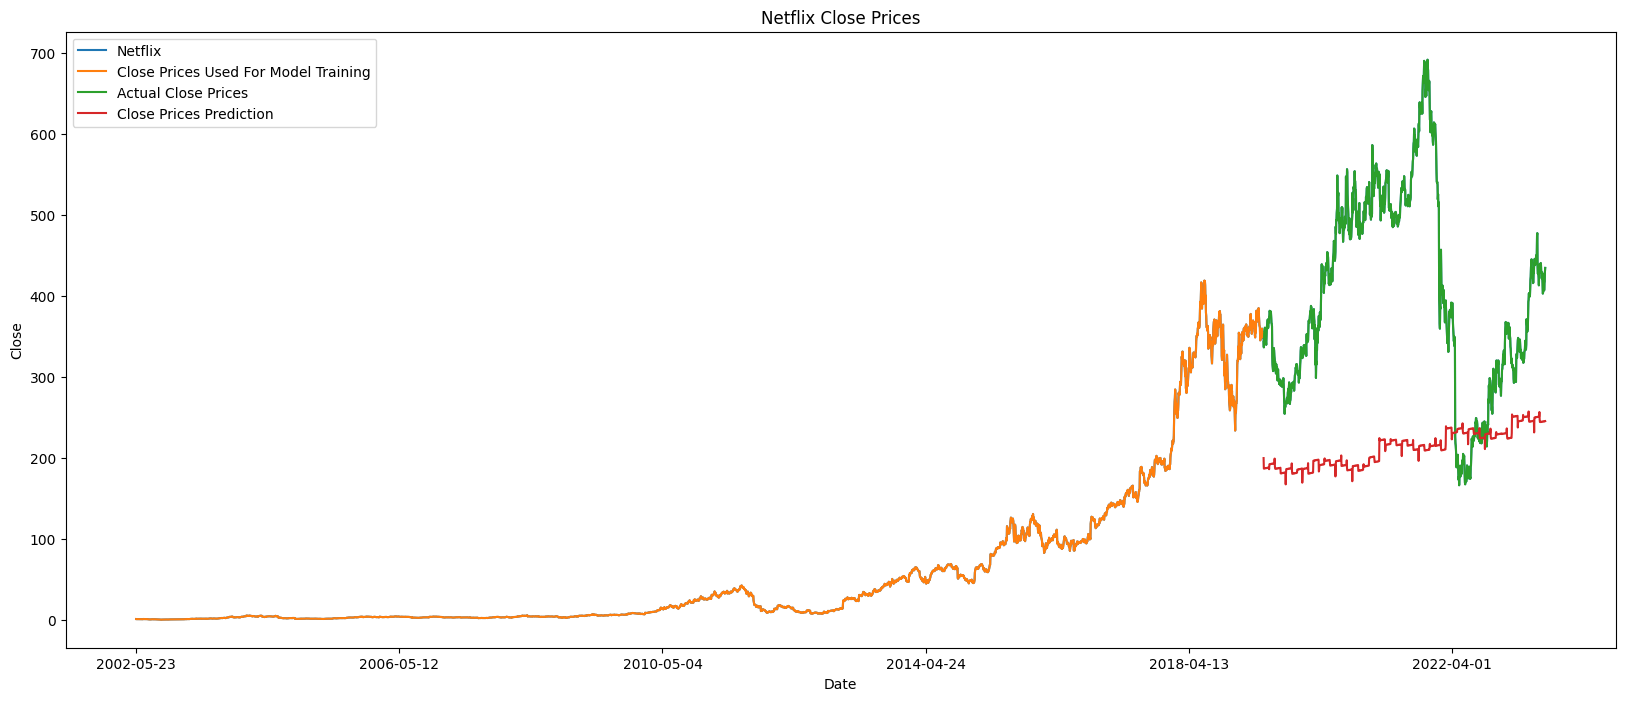

In [ ]:
valid.index = new_data[4284:].index
train.index = new_data[:4284].index
prediction = pd.DataFrame(linearRegressionPrediction, columns = ['Close'])
prediction.index = new_data[4284:].index


Netflix.plot(label = 'Netflix', figsize = (20,8), title = 'Netflix Close Prices', x = 'Date', y = 'Close')
train['Close'].plot(label = 'Close Prices Used For Model Training')
valid['Close'].plot(label = 'Actual Close Prices')
prediction['Close'].plot(label ='Close Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

**Conclusion**

Based on the close price legend, we can determine that the linear regression model performed poorly in predicting the stock prices.

Linear regression is simple to implement. However, it overfits to the date and month column. Instead of taking into account the previous values from the point of prediction. So, the model will consider the value from the same date a month ago, or the same date/month a year ago, or the same year a decade ago. Which make it unaccurate when it comes to stock prediction.

# k-Nearest Neighbours (KNN)





K-nearest neighbours is a machine learning algorithm that finds similarity between new data points and old data points. It is incredibly used as a classification model. However, it can be implemented to perfrom regression task and make predictions based on input parameters.

**Data normalization**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

We are going to use the same training and validation set from the previous model

**Data scaling**

In [ ]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

**Find the best parameter using gridsearch**

In [ ]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
KNNModel = GridSearchCV(knn, params, cv=5)

**Fit the model**

In [ ]:
KNNModel.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]})

**Make predictions**

In [ ]:
KNNPrediction = KNNModel.predict(x_valid)

**Get the RMSE**

In [ ]:
rmse=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(KNNPrediction)),2)))
rmse

379.596008758277

**Plot the predicted prices compared to the actual prices**

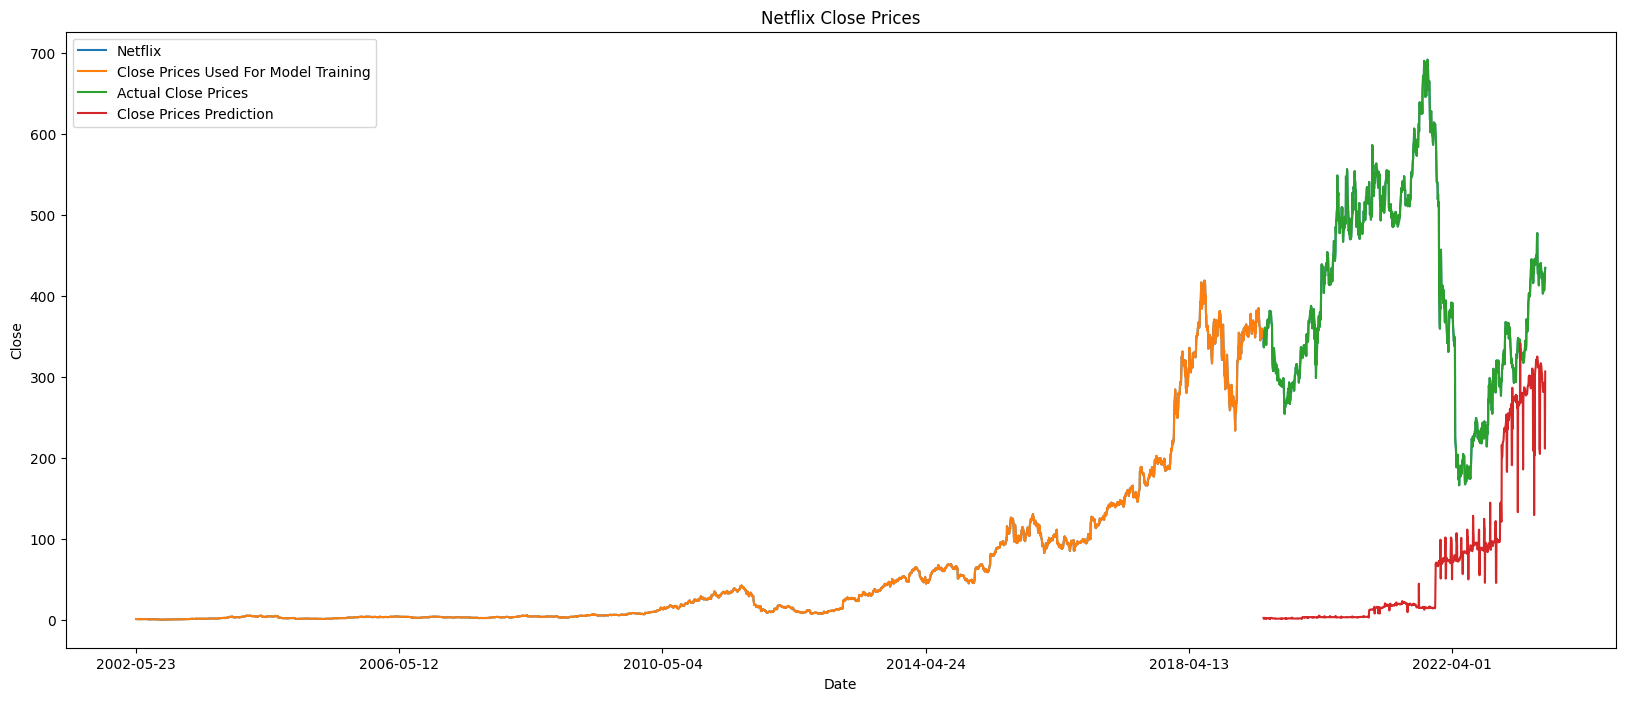

In [ ]:
valid.index = new_data[4284:].index
train.index = new_data[:4284].index
prediction = pd.DataFrame(KNNPrediction, columns = ['Close'])
prediction.index = new_data[4284:].index


Netflix.plot(label = 'Netflix', figsize = (20,8), title = 'Netflix Close Prices', x = 'Date', y = 'Close')
train['Close'].plot(label = 'Close Prices Used For Model Training')
valid['Close'].plot(label = 'Actual Close Prices')
prediction['Close'].plot(label ='Close Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

**Conclusion**

Based on the legend, we can determine that the KNN performence does not differ much from the Linear regression results. In matter of fact, since we used KNN as a regression algorithm, it also follows the same pattern when it comes to overfitting to previous months and years instead of using previous values.
As you can see, there is a drop in the starting value instead of keeping up with the legend pattern.

So, we can conclude that KNN is not valid for stock prediction along with any regression algorithm in general.

# Auto ARIMA

Auto ARIMA is an automated version of the machine learning model ARIMA (Auto-Regressive Integrated Moving Averages).

ARIMA is a statistical algorithm used for time series forecasting that takes into account the past values to predict the future values. It is a combination of Auto Regression and Moving average and relies on three important parameters:

- p (past values used for forecasting the next value)
- q (past forecast errors used to predict the future values)
- d (order of differencing)

Tuning those parameters is time consuming. So, we will use Auto ARIMA as it automatically selects the best combination of (p,q,d) that provides the least error without requiring user extensive knowledge of time series analysis.

In [ ]:
train = data[:4284]
valid = data[4284:]

training = train['Close']
validation = valid['Close']

**Implement Auto ARIMA model**

In [ ]:
AutoARIMAModel = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
AutoARIMAModel.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=9.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=23953.207, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=22798.492, Time=1.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=23944.237, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=22241.225, Time=3.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=17.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=22240.595, Time=2.41 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=22799.013, Time=0.88 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=13.46 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=5.69 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=22241.281, Time=3.73 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=22239.138, Time=7.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : 

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

The implementation of Auto ARIMA revealed that this technique can be resource consumming as the excution of this model failed at the beginning on Google Colab because it used all the System RAM. And I had to switch to Colab Pro to have enough RAM memory to run the project. Also, the excution time for this model was way more than the previous ones.

**Make predictions**

In [ ]:
AutoARIMAPrediction = AutoARIMAModel.predict(n_periods=len(validation))
AutoARIMAPrediction = pd.DataFrame(AutoARIMAPrediction,index = valid.index,columns=['Prediction'])

**Get the RMSE**

In [ ]:
rmse=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(AutoARIMAPrediction['Prediction'])),2)))
rmse

206.6870865030465

**Plot the predicted prices compared to the actual prices**

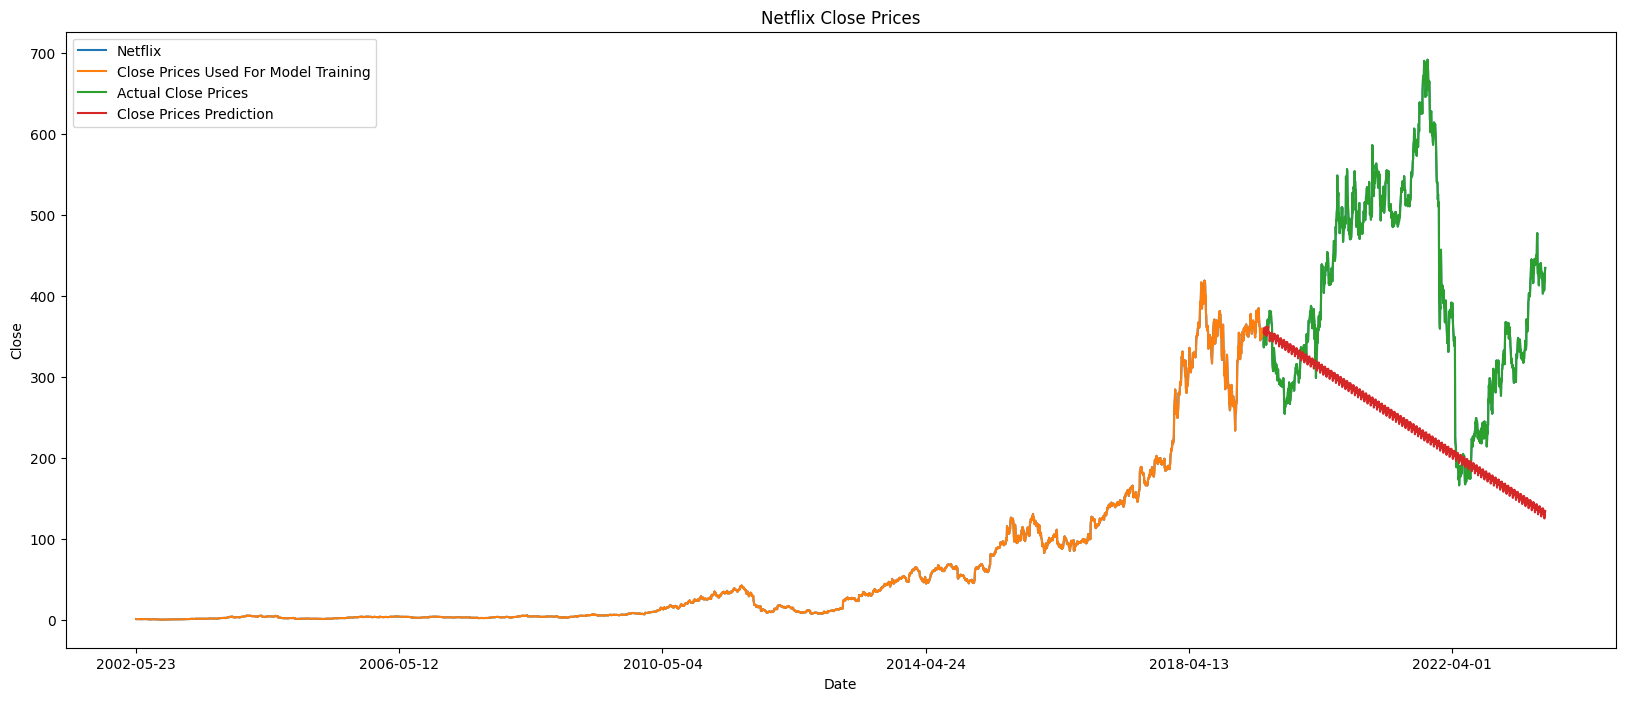

In [ ]:
valid.index = new_data[4284:].index
train.index = new_data[:4284].index
AutoARIMAPrediction.index = new_data[4284:].index

Netflix.plot(label = 'Netflix', figsize = (20,8), title = 'Netflix Close Prices', x = 'Date', y = 'Close')
train['Close'].plot(label = 'Close Prices Used For Model Training')
valid['Close'].plot(label = 'Actual Close Prices')
AutoARIMAPrediction['Prediction'].plot(label ='Close Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

**Conclusion**

The plot indicates that our model identified a decrease trend in the series where every time the stock price reach a peak, it starts decreasing straight after it. And it makes sense as Auto ARIMA uses past data to understand the pattern in the time series.

Although the result of this statistical technique is slightly better than the previous machine learning models, the predictions are still not close to the real values as Auto ARIMA did not focus on the seasonal part.

# Prophet

Prophet is a time series forecasting library created by Facebook that capture the trend and seasonality from past data.

While there are several time series techniques that can be implemented for stock prediction, those models require a lot of data preprocessing before fitting the model. On the other hand, The Prophet package provides intuitive parameters that are easy to tune even for someone who lacks expertise in forecasting models. It is extremely simple to implement and makes accurate predictions.

**Creating dataframe**

In [ ]:
new_data = pd.DataFrame(index=range(0,len(Netflix)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

**Preparing data**

In [ ]:
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

train = new_data[:4284]
valid = new_data[4284:]

**Fit the model**

In [ ]:
ProphetModel = Prophet()
ProphetModel.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ftdn0o7/x7s4mbr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ftdn0o7/kj_d_fti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69067', 'data', 'file=/tmp/tmp3ftdn0o7/x7s4mbr9.json', 'init=/tmp/tmp3ftdn0o7/kj_d_fti.json', 'output', 'file=/tmp/tmp3ftdn0o7/prophet_model_uoyt_2y/prophet_model-20230911061958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Make predictions**

In [ ]:
close_prices = ProphetModel.make_future_dataframe(periods=len(valid))
ProphetPrediction = ProphetModel.predict(close_prices)

**Get RMSE**

In [ ]:
forecast_valid = ProphetPrediction['yhat'][4284:]
rmse=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rmse

183.30966085079777

**Plot the predicted prices compared to the actual prices**

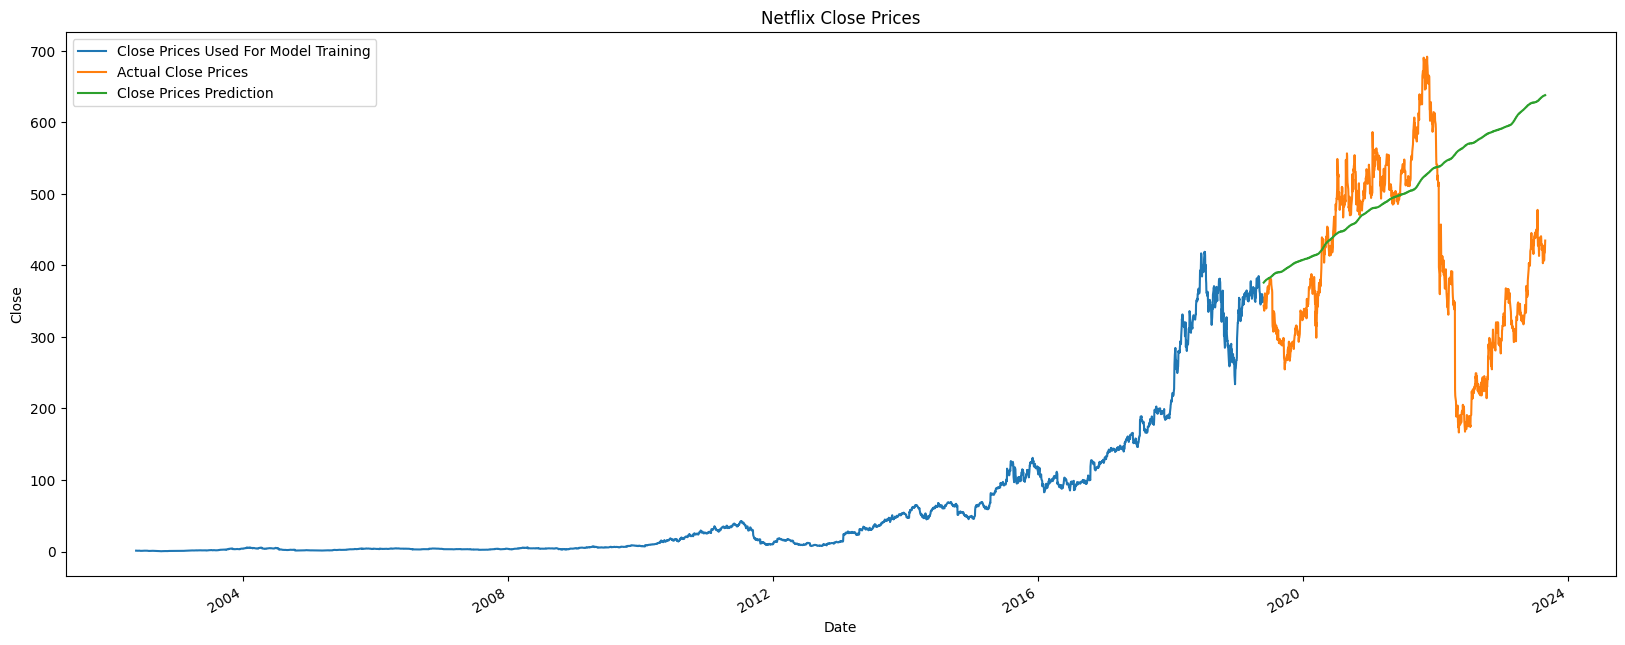

In [ ]:
ProphetPrediction = forecast_valid.values
ProphetPrediction = pd.DataFrame(ProphetPrediction,index = valid.index,columns=['Prediction'])
ProphetPrediction.index = new_data[4284:].index

valid.index = new_data[4284:].index
train.index = new_data[:4284].index

train.plot(label = 'Close Prices Used For Model Training', figsize = (20,8), title = 'Netflix Close Prices', x = 'ds', y = 'y')
valid['y'].plot(label = 'Actual Close Prices')
ProphetPrediction['Prediction'].plot(label ='Close Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

**Conclusion**

Based on the plot, we can determine that Prophet fails to live up to it's reputation when it comes to stock prediction even though the results are far better than the previous models.

Since Prophet and Auto ARIMA captures the trend and seasonality from past data, we can determine that stock prices do not follow a particular trend or seasonality. Thus, it is based on the market events and it flows accordingly.

# Long Short Term Memory (LSTM)

Long short-term memory (LSTM) is a deep learning architecture based on an artificial recurrent neural network (RNN). It is an extremely effective sequence prediction model that stores important past information, and forget trivial particulars.

LSTM has three gates:
- The input gate: The input gate adds information to the cell state
- The forget gate: It removes the information that is no longer required by the model
- The output gate: Output Gate at LSTM selects the information to be shown as output

**Creating dataframe**

In [ ]:
data = Netflix.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(Netflix)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

**Setting index**

In [ ]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

**Create train and test sets**

In [ ]:
dataset = new_data.values

train = dataset[0:4284,:]
valid = dataset[4284:,:]

**Data normalization**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(240, len(train)):
    x_train.append(scaled_data[i - 240:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

**Implement and fit model**

In [ ]:
LSTMModel = Sequential()
LSTMModel.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
LSTMModel.add(LSTM(units=50))
LSTMModel.add(Dense(1))

LSTMModel.compile(loss='mean_squared_error', optimizer='adam')
LSTMModel.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

4044/4044 - 54s - loss: 3.3762e-04 - 54s/epoch - 13ms/step


**Predict close prices using last 240 from train data**

In [ ]:
inputs = new_data[len(new_data) - len(valid) - 240:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(240,inputs.shape[0]):
    X_test.append(inputs[i-240:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTMPrediction = LSTMModel.predict(X_test)
LSTMPrediction = scaler.inverse_transform(LSTMPrediction)

34/34 [==============================] - 1s 8ms/step


**Get the RMSE**

In [ ]:
rmse=np.sqrt(np.mean(np.power((valid-LSTMPrediction),2)))
rmse

27.990742763607102

**Plot the predicted prices compared to the actual prices**

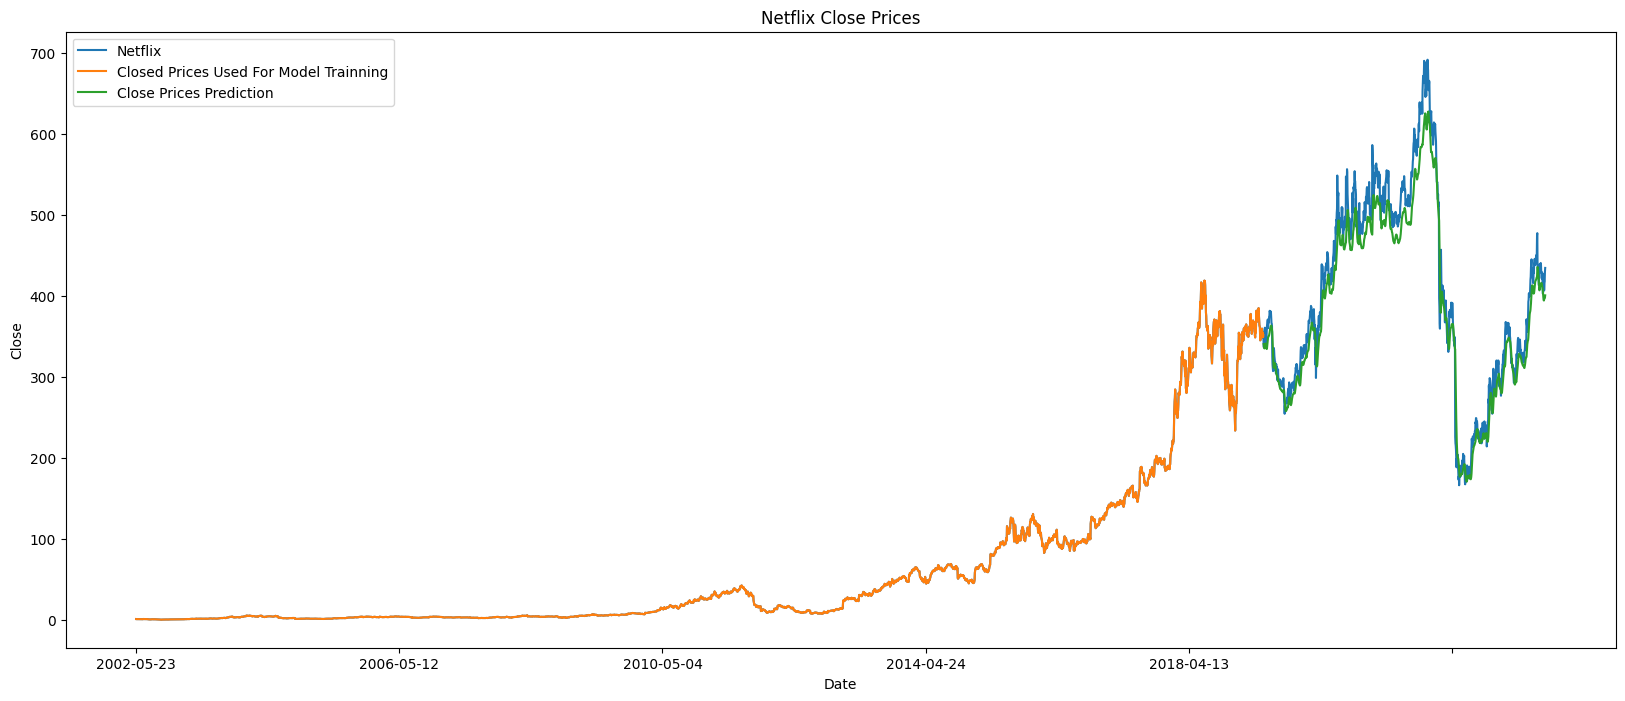

In [ ]:
train = new_data[:4284]
valid = new_data[4284:]
LSTMPrediction = pd.DataFrame(LSTMPrediction, index = valid.index, columns=['Prediction'])
LSTMPrediction.index = data[4284:].index

Netflix.plot(label = 'Netflix', figsize = (20,8), title = 'Netflix Close Prices', x = 'Date', y = 'Close')
train['Close'].plot(label = 'Closed Prices Used For Model Trainning')
#valid['Close'].plot(label = 'Actual Close Prices')
LSTMPrediction['Prediction'].plot(label ='Close Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

**Conclusion**

Based on the plot, the predicted prices are almost identical to the actual close prices of the stock which indicates that LSTM is highly accurate when it comes to quantative stock prediction. However, it is not enough to determine if the stock is going up and down as there are many other factor that effects the stock prices most importantly the market news and events.